In this notebook, we'll create a **simple Convolutional Neural Network model** in PyTorch and train it to **recognize handwritten digits in the MNIST dataset.**
1. Import PyTorch library and functions
2. Define our Transformer
3. Load our dataset
4. Inspect and Visualization our image dataset
5. Create our Data Loader for load batches of images
6. Building our Model
7. Training our Model
8. Analyizing it's Accuracy
9. Saving our Model
10. Plotting our training logs

### **1. Import our libaries and modules**

We import PyTorch by importing ```torch```. We'll be using **torchvision** which is a PyTorch package that consists of popular datasets, model acrhitectures and common image transformations.

In [1]:
import torch

import torchvision
import torchvision.transforms as transforms

import torch.optim as optim
import torch.nn as nn

print("GPU available: {}".format(torch.cuda.is_available()))

GPU available: True


In [2]:
if torch.cuda.is_available():
  device = 'cuda' 
else:
  device = 'cpu' 

### **2. We define our transformer**

Transfomers are needed to cast the image data into the required format for input into our model.

- It's composed using the ```transforms.Compose``` function
- We chain the commands or instructions for our pipeline as the arguements
- We use ```transforms.ToTensor()``` to convert the image data into a PyTorch Tensor
- We use ```transforms.Normalize()``` to normalize our pixel values
- By passing the input as ```(0.5, ), (0.5,)``` we Normalize our image data between -1 and +1 
- Note for RGB images we use ```transformed.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))``` instead

**NOTE**:
Our raw pixel values in our MNIST dataset range from 0 to 255. Each image is 28 pixels heigh and 28 pixels wide, with a depth of 1 as it's grayscale.

**Why Normalize?**

1. To ensure all features, or in our case, pixel intensities, are weighted equally when training our CNN
2. Makes training faster as it avoids oscilations during training
3. Removes and bias or skewness in our image data


**Why 0.5?**

Normalization is done like this:

`image = (image - mean) / std`

Using the parameters 0.5,0.5 sets the Mean and STD to 0.5. Using the formula above this gives us:

- Min value = `(0-0.5)/0.5 = 1`
- Max value = `(1-0.5)/0.5 = -1`

For color images we use a tuple of (0.5,0.5,0.5) to set the Mean of the RGB channels to 0.5 and another tuple of (0.5, 0.5, 0.5) to set the STD to 0.5

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, ), (0.5, )) ])

### **3. Fetch our MNIST Dataset using torchvision**

**NOTE** 

- Many online tutorials state transforms are applied upon loading. That is NOT true. Transformers are only applied when loaded by our Data Loader. 
- Our dataset is left unchanged, only batches of images loaded by the our Data Loader are copied and transformed every iteration.
- View other datasets that can be accesed via torchvision here - https://pytorch.org/vision/stable/datasets.html

In [5]:
trainset = torchvision.datasets.MNIST('mnist', 
                                      train = True, 
                                      download = True,
                                      transform = transform)

testset = torchvision.datasets.MNIST('mnist', 
                                     train = False,
                                     download = True,
                                     transform = transform)

In [6]:
print(trainset.data.shape)
print(testset.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [7]:
print(trainset.data[0].shape)
print(trainset.data[0])

torch.Size([28, 28])
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,  

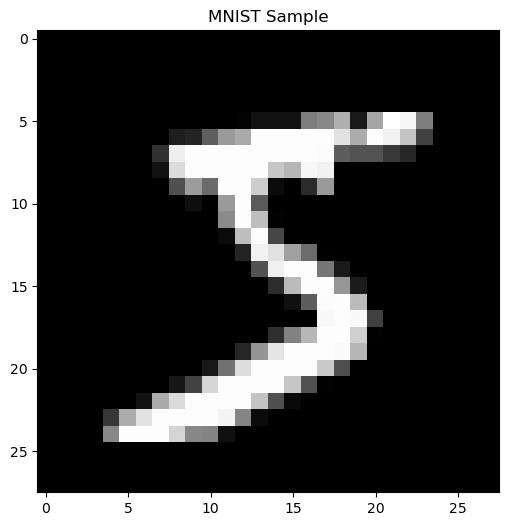

In [8]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Define our imshow function 
def imgshow(title="", image = None, size = 6):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

# Convert image to a numpy array
image = trainset.data[0].numpy()
imgshow("MNIST Sample", image)

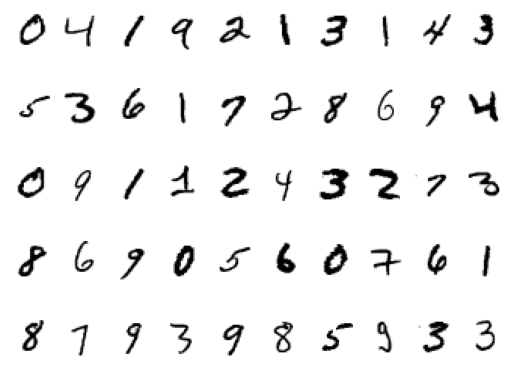

In [9]:
# Let's view the 50 first images of the MNIST training dataset
import matplotlib.pyplot as plt

figure = plt.figure()
num_of_images = 50 

for index in range(1, num_of_images + 1):
    plt.subplot(5, 10, index)
    plt.axis('off')
    plt.imshow(trainset.data[index], cmap='gray_r')

### **5. Create our Data Loader**

A **Data Loader** is a function that we'll use to grab our data in specified batch sizes (we'll use 128) during training. 

Remember we can't feed all our data through the network at once, therefore that is why we split data into batches. 

We set **shuffle** equal to True to prevent data sequence bias. For example, in some datasets the each class in usually in order, so to avoid loading batches of only a single class, we shuffle our data.

```num_workers``` specifies how many CPU cores we wish to utilize, setting it 0 means that it will be the main process that will do the data loading when needed. Leave it as 0 unless you wish to experiment futher.

In [10]:
# Prepare train and test loader
trainloader = torch.utils.data.DataLoader(trainset,
                                           batch_size = 128,
                                           shuffle = True,
                                           num_workers = 0)

testloader = torch.utils.data.DataLoader(testset,
                                          batch_size = 128,
                                          shuffle = False,
                                          num_workers = 0)

# **6. Now we build our Model**

We will use the ```nn.Sequential``` method to construct our model. Alernatively we can use the functional module, however this is simpler and more similar to styles you'll work with in Keras.

### **Building a Convolution Filter Layer**

```
nn.Conv2d(in_channels=1,
          out_channels=32,
          kernel_size=3,
          stride=1, 
          padding=1)
```

- **in_channels (int)** — This is the number of channels in the input image (for grayscale images use 1 and for RGB color images use 3)
- **out_channels (int)** — This is the number of channels produced by the convolution. We use 32 channels or 32 filters. **NOTE** 32 will be the number of **in_channels** in the next network layer.
- **kernel_size (int or tuple)** — This is the size of the convolving kernel. We use 3 here, which gives a kernel size of 3 x 3.
- **stride (int or tuple, optional)** — Stride of the convolution. (Default: 1)
- **padding (int or tuple, optional)** — Zero-padding added to both sides of the input (Default: 0). We use a padding = 1.

### **The Max Pool Layer**

- Each pooling layer i.e., nn.MaxPool2d(2, 2) halves both the height and the width of the image, so by using 2 pooling layers, the height and width are 1/4 of the original sizes.

![](https://github.com/rajeevratan84/ModernComputerVision/raw/main/CleanShot%202020-11-29%20at%204.21.04%402x.png)

In [12]:
import torch.nn as nn
import torch.nn.functional as F #

# Create our Model using a Python Class
class Net(nn.Module):
    def __init__(self):
        # super is a subclass of the nn.Module and inherits all its methods
        super(Net, self).__init__()

        # We define our layer objects here
        # Our first CNN Layer using 32 Fitlers of 3x3 size, with stride of 1 & padding of 0
        self.conv1 = nn.Conv2d(1, 32, 3)
        # Our second CNN Layer using 64 Fitlers of 3x3 size, with stride of 1 & padding of 0
        self.conv2 = nn.Conv2d(32, 64, 3)
        # Our Max Pool Layer 2 x 2 kernel of stride 2
        self.pool = nn.MaxPool2d(2, 2)
        # Our first Fully Connected Layer (called Linear), takes the output of our Max Pool
        # which is 12 x 12 x 64 and connects it to a set of 128 nodes
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        # Our second Fully Connected Layer, connects the 128 nodes to 10 output nodes (our classes)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # here we define our forward propogation sequence 
        # Remember it's Conv1 - Relu - Conv2 - Relu - Max Pool - Flatten - FC1 - FC2
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 12 * 12) # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create an instance of the model and move it (memory and operations) to the CUDA device
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [14]:
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


### **7. Defining a Loss Function and Optimizer**

We need to define what type of loss we'll be using and what method will be using to update the gradients.
1. We use Cross Entropy Loss as it is a multi-class problem
2. We use Stochastic Gradient Descent (SGD) - we also specify a learn rate (LR) of 0.001 and momentum 0.9

In [15]:
# We import our optimizer function
import torch.optim as optim

# We use Cross Entropy Loss as our loss function
criterion = nn.CrossEntropyLoss()

# For our gradient descent algorthim or Optimizer
# We use Stochastic Gradient Descent (SGD) with a learning rate of 0.001
# We set the momentum to be 0.9
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### **8. Training Our Model**

In PyTorch we use the building block functions to execute the training algorithm that we should be somewhat familar with by now.

![](https://github.com/rajeevratan84/ModernComputerVision/raw/main/CleanShot%202020-11-29%20at%207.04.32%402x.png)

In [16]:
# We loop over the traing dataset multiple times (each time is called an epoch)
epochs = 10

# Create some empty arrays to store logs 
epoch_log = []
loss_log = []
accuracy_log = []

# Iterate for a specified number of epochs
for epoch in range(epochs):  
    print(f'Starting Epoch: {epoch+1}...')

    # We keep adding or accumulating our loss after each mini-batch in running_loss
    running_loss = 0.0

    # We iterate through our trainloader iterator
    # Each cycle is a minibatch
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Move our data to GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Clear the gradients before training by setting to zero
        # Required for a fresh start
        optimizer.zero_grad()

        # Forward -> backprop + optimize
        outputs = net(inputs) # Forward Propagation 
        loss = criterion(outputs, labels) # Get Loss (quantify the difference between the results and predictions)
        loss.backward() # Back propagate to obtain the new gradients for all nodes
        optimizer.step() # Update the gradients/weights

        # Print Training statistics - Epoch/Iterations/Loss/Accuracy
        running_loss += loss.item()
        if i % 50 == 49:    # show our loss every 50 mini-batches
            correct = 0 # Initialize our variable to hold the count for the correct predictions
            total = 0 # Initialize our variable to hold the count of the number of labels iterated

            # We don't need gradients for validation, so wrap in 
            # no_grad to save memory
            with torch.no_grad():
                # Iterate through the testloader iterator
                for data in testloader:
                    images, labels = data
                    # Move our data to GPU
                    images = images.to(device)
                    labels = labels.to(device)
                    
                    # Foward propagate our test data batch through our model
                    outputs = net(images)

                     # Get predictions from the maximum value of the predicted output tensor
                     # we set dim = 1 as it specifies the number of dimensions to reduce
                    _, predicted = torch.max(outputs.data, dim = 1)
                    # Keep adding the label size or length to the total variable
                    total += labels.size(0)
                    # Keep a running total of the number of predictions predicted correctly
                    correct += (predicted == labels).sum().item()

                accuracy = 100 * correct / total
                epoch_num = epoch + 1
                actual_loss = running_loss / 50
                print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i+1)}, Loss: {actual_loss:.3f}, Test Accuracy = {accuracy:.3f}%')
                running_loss = 0.0

    # Store training stats after each epoch
    epoch_log.append(epoch_num)
    loss_log.append(actual_loss)
    accuracy_log.append(accuracy)

print('Finished Training')

Starting Epoch: 1...
Epoch: 1, Mini-Batches Completed: 50, Loss: 2.272, Test Accuracy = 36.580%
Epoch: 1, Mini-Batches Completed: 100, Loss: 2.144, Test Accuracy = 67.930%
Epoch: 1, Mini-Batches Completed: 150, Loss: 1.792, Test Accuracy = 69.700%
Epoch: 1, Mini-Batches Completed: 200, Loss: 1.107, Test Accuracy = 81.060%
Epoch: 1, Mini-Batches Completed: 250, Loss: 0.657, Test Accuracy = 85.860%
Epoch: 1, Mini-Batches Completed: 300, Loss: 0.486, Test Accuracy = 87.040%
Epoch: 1, Mini-Batches Completed: 350, Loss: 0.448, Test Accuracy = 88.790%
Epoch: 1, Mini-Batches Completed: 400, Loss: 0.414, Test Accuracy = 89.290%
Epoch: 1, Mini-Batches Completed: 450, Loss: 0.368, Test Accuracy = 90.090%
Starting Epoch: 2...
Epoch: 2, Mini-Batches Completed: 50, Loss: 0.366, Test Accuracy = 90.340%
Epoch: 2, Mini-Batches Completed: 100, Loss: 0.327, Test Accuracy = 90.340%
Epoch: 2, Mini-Batches Completed: 150, Loss: 0.338, Test Accuracy = 90.780%
Epoch: 2, Mini-Batches Completed: 200, Loss: 0.3

## **9. Saving Our Model**

We use the ```torch.save()``` function to save our model.

```net.state_dict()``` saves our model weights in a dictionay format.

In [17]:
PATH = './mnist_cnn_net.pth'
torch.save(net.state_dict(), PATH)

In [18]:
# Loading one mini-batch
dataiter = iter(testloader)
images, labels = dataiter.next()

# Display images using torchvision's utils.make_grid()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ',''.join('%1s' % labels[j].numpy() for j in range(128)))

AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'

In [ ]:
# Create an instance of the model and move it (memory and operations) to the CUDA device.
net = Net()
net.to(device)

# Load weights from the specified path
net.load_state_dict(torch.load(PATH))

In [ ]:
## Let's forward propagate one mini-batch and get the predicted outputs
# We use the Python function iter to return an iterator for our train_loader object
test_iter = iter(testloader)

# We use next to get the first batch of data from our iterator
images, labels = test_iter.next()

# Move our data to GPU
images = images.to(device)
labels = labels.to(device)

outputs = net(images)

# Get the class predictions using torch.max
_, predicted = torch.max(outputs, 1)

# Print our 128 predictions
print('Predicted: ', ''.join('%1s' % predicted[j].cpu().numpy() for j in range(128)))

In [ ]:
correct = 0 
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Move our data to GPU
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10000 test images: {accuracy:.3}%')

## **10. Plotting our Training Logs**

Remember we created some lists to log our training stats?

```
# Create some empty arrays to store logs 
epoch_log = []
loss_log = []
accuracy_log = []
```

**Let's now plot those logs**

In [ ]:
# To create a plot with secondary y-axis we need to create a subplot
fig, ax1 = plt.subplots()

# Set title and x-axis label rotation
plt.title("Accuracy & Loss vs Epoch")
plt.xticks(rotation=45)

# We use twinx to create a plot a secondary y axis
ax2 = ax1.twinx()

# Create plot for loss_log and accuracy_log
ax1.plot(epoch_log, loss_log, 'g-')
ax2.plot(epoch_log, accuracy_log, 'b-')

# Set labels
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='g')
ax2.set_ylabel('Test Accuracy', color='b')

plt.show()

In [ ]:
epoch_log = list(range(1,11))
epoch_log

In [ ]:
list(range(1,10))

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# We don't need gradients for validation, so wrap in 
# no_grad to save memory
with torch.no_grad():
    for data in testloader:
        images, labels = data

        # Move our data to GPU
        images = images.to(device)
        labels = labels.to(device)

        # Get our outputs
        outputs = net(images)

        # use torch.max() to get the predicted class for the first dim of our batch
        # note this is just the first 16 data points/images of our batch of 128 images 
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        for i in range(15):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    class_accuracy = 100 * class_correct[i] / class_total[i]
    print(f'Accuracy of {i} : {class_accuracy:.3f}%')

In [ ]:
net.eval()

# We don't need gradients for validation, so wrap in 
# no_grad to save memory
with torch.no_grad():
    for data in testloader:
        images, labels = data

        # Move our data to GPU
        images = images.to(device)
        labels = labels.to(device)

        # Get our outputs
        outputs = net(images)

        # use torch.argmax() to get the predictions, argmax is used for long_tensors
        predictions = torch.argmax(outputs, dim=1)

        # For test data in each batch we identify when predictions did not match the label
        # then we print out the actual ground truth 
        for i in range(data[0].shape[0]):
            pred = predictions[i].item()
            label = labels[i]
            if(label != pred):
                print(f'Actual Label: {pred}, Predicted Label: {label}')       
                img = np.reshape(images[i].cpu().numpy(),[28,28])
                imgshow("", np.uint8(img), size = 1)

In [ ]:
nb_classes = 10

confusion_matrix = torch.zeros(nb_classes, nb_classes)

with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

In [ ]:
print(confusion_matrix.diag()/confusion_matrix.sum(1))

In [ ]:
from sklearn.metrics import confusion_matrix

nb_classes = 10

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

In [ ]:
from sklearn.metrics import confusion_matrix

nb_classes = 9

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)